In [ ]:
! pip install wandb

In [ ]:
! wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
import wandb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = torch.device("cuda")

In [ ]:
from torchvision.transforms.transforms import Resize
class CustomDataset(Dataset):
  def __init__(self,folder_img, folder_mask):
    self.path_img = sorted(list(filter(None,[os.path.join(folder_img,i) if "tiff" in i else None for i in os.listdir(folder_img)])))
    self.path_mask = sorted(list(filter(None,[os.path.join(folder_mask,i) if "tiff" in i else None for i in os.listdir(folder_mask)])))

  def transformation(self, path):
    img = Image.open(path)

    transform = transforms.Compose([
        # transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    return transform(img)

  def __getitem__(self, index):
    return self.transformation(self.path_img[index]),self.transformation(self.path_mask[index])

  def __len__(self):
    return len(self.path_img)

In [ ]:
train_dataset = CustomDataset("/content/gdrive/MyDrive/train","/content/gdrive/MyDrive/train_mask")
train_dataloader = DataLoader(train_dataset, batch_size = 5, shuffle = True, num_workers = 1, pin_memory = True)

In [ ]:
size = 256 # patch size
stride = 256 # patch stride
channels_img = 3
channels_mask = 1
for img, mask in train_dataloader:
  img = img.to(device)
  mask = mask.to(device)
  img = img.unfold(1,channels_img,channels_img).unfold(2, size, stride).unfold(3, size, stride)
  img = img.reshape(img.size(0)*img.size(2)*img.size(3),channels_img,size,size)
  mask = mask.unfold(1,1,1).unfold(2, size, stride).unfold(3, size, stride)
  mask = mask.reshape(mask.size(0)*mask.size(2)*mask.size(3),channels_mask,size,size)

In [ ]:
class PatchedImageLoader(Dataset):
  def __init__(self,patched_tensor_imgs, patched_tensor_masks):
    self.patched_tensor_imgs = patched_tensor_imgs
    self.patched_tensor_masks = patched_tensor_masks

  def __getitem__(self, index):
      return self.patched_tensor_imgs[index], self.patched_tensor_masks[index]

  def __len__(self):
    return self.patched_tensor_imgs.size(0)

In [ ]:
class Unet(torch.nn.Module):
    def __init__(self, n_classes = 1, channels = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding = 'same')
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3, padding = 'same')
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(4, 8, kernel_size=3, padding = 'same')
        self.dropout2 = nn.Dropout(0.2)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding = 'same')
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(8, 16, kernel_size=3, padding = 'same')
        self.dropout3 = nn.Dropout(0.2)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, padding = 'same')
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv7 = nn.Conv2d(16, 32, kernel_size=3, padding = 'same')
        self.dropout4 = nn.Dropout(0.2)
        self.conv8 = nn.Conv2d(32, 32, kernel_size=3, padding = 'same')
        self.maxpool4 = nn.MaxPool2d(2)

        self.conv9 = nn.Conv2d(32, 64, kernel_size=3, padding = 'same')
        self.dropout5 = nn.Dropout(0.2)
        self.conv10 = nn.Conv2d(64, 64, kernel_size=3, padding = 'same')

        self.transConv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(64, 32, kernel_size=3, padding = 'same')
        self.dropout6 = nn.Dropout(0.2)
        self.conv12 = nn.Conv2d(32, 32, kernel_size=3, padding = 'same')

        self.transConv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(32, 16, kernel_size=3, padding = 'same')
        self.dropout7 = nn.Dropout(0.2)
        self.conv14 = nn.Conv2d(16, 16, kernel_size=3, padding = 'same')

        self.transConv3 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(16, 8, kernel_size=3, padding = 'same')
        self.dropout8 = nn.Dropout(0.2)
        self.conv16 = nn.Conv2d(8, 8, kernel_size=3, padding = 'same')

        self.transConv4 = nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(8, 4, kernel_size=3, padding = 'same')
        self.dropout9 = nn.Dropout(0.2)
        self.conv18 = nn.Conv2d(4, 4, kernel_size=3, padding = 'same')

        self.final_conv = nn.Conv2d(4, n_classes, kernel_size=1, padding = 'same')

    def forward(self, x):
        """ Encoder """
        x1 = nn.ReLU()(self.conv1(x))
        x1 = self.dropout1(x1)
        x1 = nn.ReLU()(self.conv2(x1))
        p1 = self.maxpool1(x1)

        x2 = nn.ReLU()(self.conv3(p1))
        x2 = self.dropout2(x2)
        x2 = nn.ReLU()(self.conv4(x2))
        p2 = self.maxpool2(x2)

        x3 = nn.ReLU()(self.conv5(p2))
        x3 = self.dropout3(x3)
        x3 = nn.ReLU()(self.conv6(x3))
        p3 = self.maxpool3(x3)

        x4 = nn.ReLU()(self.conv7(p3))
        x4 = self.dropout4(x4)
        x4 = nn.ReLU()(self.conv8(x4))
        p4 = self.maxpool4(x4)

        """Transfer block"""
        x5 = nn.ReLU()(self.conv9(p4))
        x5 = self.dropout5(x5)
        x5 = nn.ReLU()(self.conv10(x5))

        """ Decoder """
        u6 = self.transConv1(x5)
        u6 = torch.cat((u6, x4), 1)
        x6 = nn.ReLU()(self.conv11(u6))
        x6 = self.dropout6(x6)
        x6 = nn.ReLU()(self.conv12(x6))

        u7 = self.transConv2(x6)
        u7 = torch.cat((u7, x3), 1)
        x7 = nn.ReLU()(self.conv13(u7))
        x7 = self.dropout7(x7)
        x7 = nn.ReLU()(self.conv14(x7))

        u8 = self.transConv3(x7)
        u8 = torch.cat((u8, x2), 1)
        x8 = nn.ReLU()(self.conv15(u8))
        x8 = self.dropout8(x8)
        x8 = nn.ReLU()(self.conv16(x8))

        u9 = self.transConv4(x8)
        u9 = torch.cat((u9, x1), 1)
        x9 = nn.ReLU()(self.conv17(u9))
        x9 = self.dropout9(x9)
        x9 = nn.ReLU()(self.conv18(x9))

        '''Classifier'''
        output = self.final_conv(x9)
        return output

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()  # setting model to train mode
    for imgs, labels in train_loader:  # trainloader returns a tuple -> (batch of images, corresponding vector of labels)
        # Feed-forward Section
        imgs = imgs.to(device)  # shift images to GPU for faster training
        labels = labels.to(device)  # shift labels to GPU for faster training
        outputs = model(imgs)  # output of feed-forward neural network before softmax layer
        # Back-propagation Section
        loss = F.binary_cross_entropy(outputs, labels)  # calculate the softmax output and loss per batch of the images
        train_loss+=loss.item()
        optimizer.zero_grad()  # set the gradients matrix to zero before calculating the gradients for every batch
        loss.backward()  # calculate the gradients through differentiation (dL/dW)
        optimizer.step()  # update of weights (w = w - dL/dW)

    wandb.log({
        "Train Loss": train_loss/(len(train_loader.dataset)/imgs.size(0))})

In [ ]:
def test(args, model, device, test_loader, classes):
    test_loss = 0  # keep track of test loss
    model.eval()  # set model in evaluation mode for test accuracy calculation

    example_images = []
    with torch.no_grad():  # no gradient calculations required during testing
        for imgs, labels in test_loader:
            imgs = imgs.to(device)  # shift images to GPU
            labels = labels.to(device)  # shift labels to GPU
            scores = model(imgs)  # predictions vector containing probability of each digit
            test_loss += F.binary_cross_entropy(scores, labels, reduction='mean').item()
            pred = (scores > 0.5).long()
            # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
            example_images.append(wandb.Image(
                imgs[:16], caption="Pred: {} Truth: {}".format(pred[:16],labels[:16].unsqueeze(1))))
    # WandB – wandb.log(a_dict) logs the keys and values of the dictionary passed in and associates the values with a step.
    # You can log anything by passing it to wandb.log, including histograms, custom matplotlib objects, images, video, text, tables, html, pointclouds and other 3D objects.
    # Here we use it to log test accuracy, loss and some test images (along with their true and predicted labels).
    wandb.log({
        "Examples": example_images,
        "Test Loss": test_loss})

In [ ]:
# load datasets
train_dataset = PatchedImageLoader(img.cpu(), mask.cpu())
# test_dataset = ImageFolder("Image Classification Data/data/test", transform)

# WandB – Initialize a new run
wandb.init(entity="ajinkya98", project="pytorch-cell-segmentation")
wandb.watch_called = False  # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config  # Initialize config
config.batch_size = 32  # input batch size for training (default: 64)
config.test_batch_size = 1000  # input batch size for testing (default: 1000)
config.epochs = 30  # number of epochs to train (default: 10)
config.lr = 0.001  # learning rate (default: 0.01)
# config.momentum = 0.1          # SGD momentum (default: 0.5)
config.no_cuda = False  # disables CUDA training
config.seed = 42  # random seed (default: 42)
config.log_interval = 10  # how many batches to wait before logging training status

wandb: Currently logged in as: ajinkya98 (use `wandb login --relogin` to force relogin)


In [ ]:
use_cuda = not config.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

# Set random seeds and deterministic pytorch for reproducibility
# random.seed(config.seed)       # python random seed
torch.manual_seed(config.seed)  # pytorch random seed
# numpy.random.seed(config.seed) # numpy random seed
torch.backends.cudnn.deterministic = True

# Now we load our training and test datalaoders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, **kwargs)
# test_loader = DataLoader(test_dataset, batch_size=config.test_batch_size, shuffle=True, **kwargs)

## loading the Unet Model
# model = Unet().to(device)

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)

## Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

# WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(model, log="all")

for epoch in range(1, config.epochs + 1):
    train(config, model, device, train_loader, optimizer, epoch)
    # test(config, model, device, test_loader, classes)

# WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
torch.save(model.state_dict(), "model_unet.h5")
wandb.save('model_unet.h5')

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


['/content/wandb/run-20220501_235401-6q1v20kx/files/model_unet.h5']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}
train_dataset = PatchedImageLoader(img.cpu(), mask.cpu())
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [ ]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)
# model.load_state_dict(torch.load("/content/model_unet(20 epochs).h5"))
# model.eval()

# mask = torch.zeros((17*256,18*256)).to(device)
# counter_row = 0
# counter_col = 0 
# for img,_ in train_dataloader:
#   out = model(img.to(device))
#   mask[counter_row:counter_row+256,counter_col:counter_col+256] = out.squeeze(1)[0]
#   if counter_col < (18 - 1):
#     counter_col+=1
#   else:
#     counter_row+=1
#     counter_col = 0

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


RuntimeError: ignored

In [ ]:
batch_imgs = torchvision.utils.make_grid(out, nrow = 4)
batch_masks = torchvision.utils.make_grid(mask, nrow = 4)

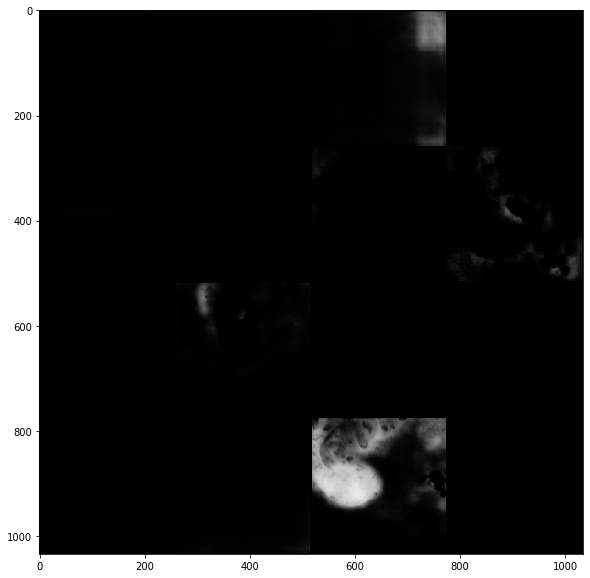

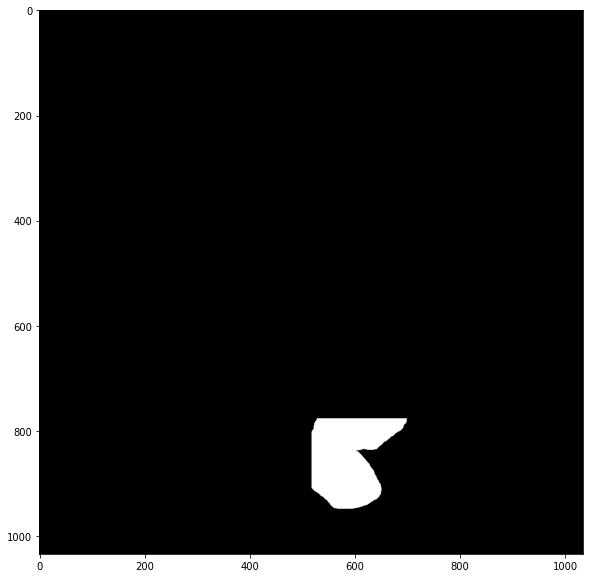

In [ ]:
plt.figure(figsize= (10,10))
plt.imshow(batch_imgs.permute(1,2,0).squeeze(2).detach().cpu().numpy(),interpolation='nearest')
plt.figure(figsize= (10,10))
plt.imshow(batch_masks.permute(1,2,0).squeeze(2).detach().cpu().numpy())